In [1]:
import torch
import joblib
import numpy as np
import pandas as pd
import anndata as ad
import scanpy as sc
from pathlib import Path
from tqdm import tqdm
from exceiver.models import ExceiverClassifier
from exceiver.datasets import ExceiverDataset, ExceiverDataModule
from torch.utils.data import DataLoader, BatchSampler, SequentialSampler

In [2]:
# Set up constants for data loading
data_path = Path(f"/scratch/ukhan/ndcn/processed")
batch_size = 64
gpu = "cuda:1"

# Create data loader
dm = ExceiverDataModule(data_path=data_path, classify="Braak", batch_size=64, num_workers=0)
dm.prepare_data()
dm.setup(stage='fit')
val_dataset = ExceiverDataset(dm.val_adata.X, classes=dm.val_classes, scaler=dm.val_scaler, n_mask=dm.n_mask, batch_size=batch_size, inference=True)
sampler = BatchSampler(SequentialSampler(val_dataset), batch_size=val_dataset.batch_size, drop_last=True)
dl = DataLoader(val_dataset, batch_size=None, batch_sampler=None, sampler=sampler, num_workers=0, pin_memory=True)

# Load model
model = ExceiverClassifier.load_from_checkpoint(checkpoint_path="../new_models/lightning_logs/finetune/checkpoints/last.ckpt")
_ = model.eval()
_ = model.to(gpu)

# Get embeddings
emb = []
for batch in tqdm(dl):
    with torch.no_grad():
        batch = [i.to(gpu) if i is not None else i for i in batch]
        gene_ids, gene_vals, mask_ids, mask_vals, key_padding_mask, classify = batch
        input_query = model.query_emb.repeat(len(gene_ids), 1, 1)
        latent, encoder_weights = model.encoder_attn_step(gene_ids, gene_vals, input_query, key_padding_mask)
        latent = model.process_self_attn(latent)
        emb.append(latent.reshape(batch_size, -1).cpu())

# Concatenate and save to disk
emb = torch.cat(emb).numpy()
joblib.dump(emb, f"/scratch/ukhan/ndcn/emb.joblib")

# Covnvert to AnnData object
emb_adata = ad.AnnData(X=emb.copy(), obs=dm.val_adata.obs[:len(emb)], var=pd.DataFrame({"emb_dim": np.arange(emb.shape[1])}))

# Compute UMAP
sc.pp.pca(emb_adata)
print("Computed PCA.")
sc.pp.neighbors(emb_adata, use_rep="X_pca")
print("Computed neighborhood graph.")
sc.tl.umap(emb_adata)
print("Computed UMAP.")

# Save to disk
emb_adata.write_h5ad(f"/scratch/ukhan/ndcn/emb.h5ad")
print("Saved AnnData object to disk.")

n masked genes: 270
train_adata shape: (15992, 19067)
val_adata shape: (6844, 19067)
preparing class labels for Braak


100%|██████████| 106/106 [00:08<00:00, 12.45it/s]
/srv/home/ukhan/miniconda3/envs/ndcn/lib/python3.11/site-packages/anndata/_core/anndata.py:117: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


Computed PCA.


/srv/home/ukhan/miniconda3/envs/ndcn/lib/python3.11/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/srv/home/ukhan/miniconda3/envs/ndcn/lib/python3.11/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/srv/home/ukhan/miniconda3/envs/ndcn/lib/python3.11/site-packages/

Computed neighborhood graph.
Computed UMAP.
Saved AnnData object to disk.


/srv/home/ukhan/miniconda3/envs/ndcn/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


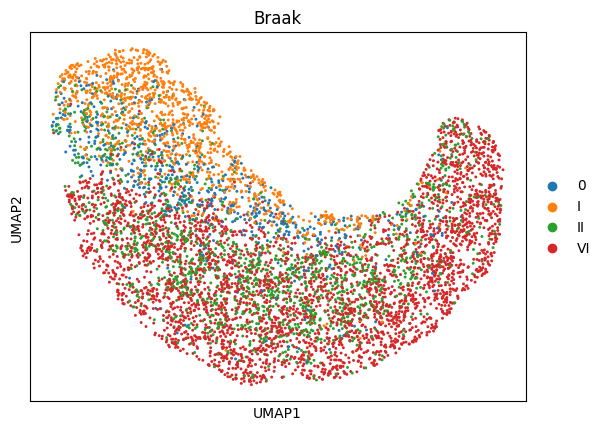

In [3]:
sc.pl.umap(emb_adata, color = "Braak")